# Mini project D7041E: 

#### Group 33

#### For our project, we have decided we are going to compare the performance of two different object detection algorithm approaches. For the first one, we are going to create our own network using PyTorch, while for the second one, will use an already existing out-of-the-box architecture: YoloV3. Along the project, we are also going to use two datasets as we strive to get the maximum grade, i.e: 5 - Using two datasets and two different algorithms.

Dataset gotten from: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit

We are in fact using two Datasets, the full version of the downloaded one, and a reduced version that only includes a certain kind of samples with only one object per sample to be detected.

# *First, we will generate our own network which we will train in one of the Datasets and later on evaluate its performance.*

In [1]:
# import the necessary packages
import torch
import os
from torch.utils.data import Dataset
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
import cv2
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
import xml.etree.ElementTree as ET
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50, resnet18
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import os
from sklearn.model_selection import KFold
import math
from torch import nn
import argparse
import imutils
import sys

# define the base path to the input dataset and then use it to derive the path to the input images and annotation XML files
BASE_PATH = "VOC2012"
IMAGES_PATH_REDUCED = os.path.sep.join([BASE_PATH, "Images_Reduced"])
ANNOTS_PATH_REDUCED = os.path.sep.join([BASE_PATH, "Annotations_Reduced"])

# define the path to the base output directory where we will store the model itself as well as the label encoder and the plots from the training
BASE_OUTPUT = "output"
os.makedirs(BASE_OUTPUT, exist_ok=True)

# define the path to the output model, label encoder, plots output directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
os.makedirs(PLOTS_PATH, exist_ok=True)

## Model declaration
We declare the model, which is going to be composed of a base pretrained model that will take care both of the box regressor and the image classifier 

In [3]:
class ObjectDetector(Module):
	def __init__(self, baseModel, numClasses):
		super(ObjectDetector, self).__init__()
		# initialize the base model and the number of classes
		self.baseModel = baseModel
		self.numClasses = numClasses
		# build the regressor head for outputting the bounding box coordinates
		self.regressor = Sequential(
			Linear(self.baseModel.fc.in_features, 128),
			ReLU(),
			Linear(128, 64),
			ReLU(),
			Linear(64, 32),
			ReLU(),
			Linear(32, 4),
			Sigmoid()
		)
		# build the classifier head to predict the class labels
		self.classifier = Sequential(
			Linear(self.baseModel.fc.in_features, 512),
			ReLU(),
			Dropout(),
			Linear(512, 512),
			ReLU(),
			Dropout(),
			Linear(512, self.numClasses)
		)
		# This next step essentially removes the last layer (it does not remove it but it multiplies all the previous outputs by 1), keeping the convolutional
		# features of the base model without the classifying part.
		self.baseModel.fc = Identity()
		
	def forward(self, x):
		# pass the inputs through the base model and then obtain predictions from two different branches of the network
			features = self.baseModel(x)
			bboxes = self.regressor(features)
			classLogits = self.classifier(features)
			# return the outputs as a tuple
			return (bboxes, classLogits)
		

## Data preprocessing

We are going to preprocess the data in a way that we do not need to use the samples with more than one bounding box as our architecture will only work with one object per image, only run it if the "reduced" folders are not built in the workspace, we do this through the use of the "Dataset_Reducer.py" script. Therefore in our project we work with two datasets, one being a simplified version of the other one.

Down here we have the parameter initialization

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'The device to train is {DEVICE}!')
PIN_MEMORY = True if DEVICE == "cuda" else False
# specify mean and standard deviation for the images to be processed by the base model
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# initialize our initial learning rate, number of epochs to train for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32
# specify the loss weights
LABELS = 1.0
BBOX = 1.0 #It feels that the predicted label is not that bad but the bounding box could be better

The device to train is cuda!


Now we instantiate a custom Dataset class which will contain our samples with their labels and bounding boxes

In [5]:
# import the necessary packages
class CustomTensorDataset(Dataset):
	# initialize the constructor
	def __init__(self, tensors, transforms=None):
		self.tensors = tensors
		self.transforms = transforms
		

	def __getitem__(self, index):
		# grab the image, label, and its bounding box coordinates
		image = self.tensors[0][index]
		label = self.tensors[1][index]
		bbox = self.tensors[2][index]
		# transpose the image such that its channel dimension becomes the leading one
		image = image.permute(2, 0, 1)
		if self.transforms:
			image = self.transforms(image)
		# return a tuple of the images, labels, and bounding box coordinates
		return (image, label, bbox)
	def __len__(self):
		# return the size of the dataset
		return self.tensors[0].size(0)

One of the first steps for adapting our data to our Dataset format is to create lists where to put the data we want to include in our Dataset, in our case we will create lists for the image itself, the labels, and the bounding boxes.

In [6]:
# Initialize lists to store data
data = []
labels = []
bboxes = []
imagePaths = []

# loop over all XML files in the annotations directory
for xmlPath in paths.list_files(ANNOTS_PATH_REDUCED, validExts=(".xml")):
    # load the contents of the current XML annotations file
    tree = ET.parse(xmlPath)
    root = tree.getroot()

    # extract information from XML
    filename = root.find("filename").text
    label = root.find(".//name").text
    xmin = float(root.find(".//xmin").text)
    ymin = float(root.find(".//ymin").text)
    xmax = float(root.find(".//xmax").text)
    ymax = float(root.find(".//ymax").text)

    # derive the path to the input image, load the image (in OpenCV format), and grab its dimensions
    imagePath = os.path.sep.join([IMAGES_PATH_REDUCED, filename])
    image = cv2.imread(imagePath)

    (h, w) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial dimensions of the input image
    startX = xmin / w
    startY = ymin / h
    endX = xmax / w
    endY = ymax / h

    # load the image and preprocess it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # update our list of data, class labels, bounding boxes, and image paths
    data.append(image)
    labels.append(label)
    bboxes.append((startX, startY, endX, endY))

For faster processing of data, the lists are converted into numpy arrays. Since the labels are in string format, we use scikit-learn’s LabelEncoder to transform them into their respective indices.

In [8]:
# convert the data, class labels, bounding boxes, and image paths to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

Now we will prepare the training and testing partitions with scikit's train_test_split

In [17]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, test_size=0.20, random_state=42)
# unpack the data split
(trainImages, TestImages) = split[:2] #Although these variables are called test, they are used for validation during the training process
(trainLabels, TestLABELS) = split[2:4]
(trainBBoxes, TestBBOXES) = split[4:]

We convert the images, labels, and bounding boxes to tensors so that they can be passed to our custom Dataset class.

As of now, our required entities are just tensors. So, to turn them into a PyTorch DataLoader accepted format, we create training and testing instances of the CustomTensorDataset class, passing the images, labels, and the bounding boxes as arguments.

The steps per epoch values are calculated using the length of the datasets and the batch size value set earlier in the notebook.

Finally, we pass the CustomTensorDataset instances through the DataLoader and create the train and test Data loader for testing, as we will create a different type of Dataloader for the training later on since we will be using cross validation and we will need a different loader for each fold.

In [18]:
# convert NumPy arrays to PyTorch tensors
(trainImages, TestImages) = torch.tensor(trainImages),torch.tensor(TestImages)
(trainLabels, TestLABELS) = torch.tensor(trainLabels),torch.tensor(TestLABELS)
(trainBBoxes, TestBBOXES) = torch.tensor(trainBBoxes),torch.tensor(TestBBOXES)
# define normalization transforms
transforms = transforms.Compose([
	transforms.ToPILImage(),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

# convert NumPy arrays to PyTorch datasets
trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes), transforms=transforms)
TestDS = CustomTensorDataset((TestImages, TestLABELS, TestBBOXES), transforms=transforms)

print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(TestDS)))

# create data loader for testing since the one for training will be created  for each iteration of the Cross Validation

testLoader = DataLoader(TestDS, batch_size= BATCH_SIZE, pin_memory= PIN_MEMORY)

[INFO] total training samples: 3200...
[INFO] total test samples: 800...


#### Model instantiation
For the base model in our architecture, we’ll be using a pre-trained resnet50. However, as mentioned before, the weights of the base model will be left untouched. Hence, we freeze the weights. Below, we instantiate the base model and prevent it from updating by locking its weights, once that is done we can instantiate a full model and so we do. With the model prerequisites complete, we create our custom model instance and load it to the current device. For the classifier loss, Cross-Entropy loss is being used, while for the Box Regressor, we are sticking to Mean squared error loss. Adam is set as the Object Detector optimizer.  



In [19]:
# load the ResNet50 network which is the base model, we could use some other base model here such as resnet18 instead
resnet = resnet50(pretrained=True)
# freeze all ResNet50 layers so they will *not* be updated during the training process
for param in resnet.parameters():
	param.requires_grad = False

# create our custom object detector model and flash it to the current device
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(DEVICE)
# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=INIT_LR, weight_decay=1e-5) #We also add L2 regularization to the optimization process to avoid overfitting and achieve 
																	   #a better generalization


c:\Users\sexysehe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sexysehe\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training process:

For training speed assessment, the start time is noted. Looping over the number of folds (we are using cross validation) and epochs, we first set the object detector to training mode and initialize the losses and number of correct predictions. To track the training loss and other metrics, a list of dictionaries H is initialized.

In [20]:
#we will use this function to reinitialize the weights of the network after each fold, by not applying a manual seed, the seed will be different
#for each initialization which is great
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data)


k = 5
kf = KFold(n_splits = k) #We create the KFold object for cross validation

# initialize a list of dictionaries to store training history
H = []
for i in range (k):
	H.append({"total_train_loss": [], "total_val_loss": [], "train_class_acc": [], "val_class_acc": []})

startTime = time.time()
bestLoss = math.inf #since we are using cross validation, we want to stick with the model that yields the best results, so we will base that on the model
#that provides us with the best validation loss

# calculate steps per epoch for training and validation set
trainSteps = (len(trainDS)*((k-1)/k)) // BATCH_SIZE
valSteps = (len(trainDS)*(1/k)) // BATCH_SIZE

for fold, (train_ids, test_ids) in enumerate(kf.split(trainDS)):
	# loop over epochs
	print("[INFO] training the network in the fold: {}/{}...".format(fold+1, k))
	    # Sample elements randomly from a given list of ids, no replacement.
	train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
	val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
	trainloader = torch.utils.data.DataLoader(trainDS,batch_size=BATCH_SIZE, sampler=train_subsampler)
	valloader = torch.utils.data.DataLoader(trainDS,batch_size=BATCH_SIZE, sampler=val_subsampler)

	objectDetector.regressor.apply(weights_init) #here the previously disclosed random initialization takes place, we initialize the weights for both 
	objectDetector.classifier.apply(weights_init)#models

	#We declare a couple of variables that will store some statistics for metrics calculus later on.
	num_classes = len(le.classes_)# Set the number of classes
	tp = torch.zeros(num_classes)
	fp = torch.zeros(num_classes)
	fn = torch.zeros(num_classes)

	for e in tqdm(range(NUM_EPOCHS)):
		# set the model in training mode
		objectDetector.train()
		# initialize the total training and validation loss
		totalTrainLoss = 0
		totalValLoss = 0
		# initialize the number of correct predictions in the training and validation step
		trainCorrect = 0
		valCorrect = 0
			# loop over the training set
		for (images, labels, bboxes) in trainloader:
			# send the input to the device
			(images, labels, bboxes) = (images.to(DEVICE), labels.to(DEVICE), bboxes.to(DEVICE))
			# perform a forward pass and calculate the training loss
			predictions = objectDetector(images)
			bboxLoss = bboxLossFunc(predictions[0], bboxes)
			classLoss = classLossFunc(predictions[1], labels)
			totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
			# zero out the gradients, perform the backpropagation step, and update the weights
			opt.zero_grad()
			totalLoss.backward()
			opt.step()
			# add the loss to the total training loss so far and calculate the number of correct predictions
			totalTrainLoss += totalLoss
			trainCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()
			# switch off autograd for evaluation
			if e == NUM_EPOCHS - 1:
				for i in range(num_classes):
					tp[i] += ((predictions[1].argmax(1) == i) & (labels == i)).sum().item()
					fp[i] += ((predictions[1].argmax(1) == i) & (labels != i)).sum().item()
					fn[i] += ((predictions[1].argmax(1) != i) & (labels == i)).sum().item()
		if e == NUM_EPOCHS - 1:
			precision = tp / (tp + fp + 1e-8)  # Add a small epsilon to avoid division by zero
			recall = tp / (tp + fn + 1e-8)
			avg_precision = np.mean(precision.cpu().numpy())
			avg_recall = np.mean(recall.cpu().numpy())
			

		with torch.no_grad():
			# set the model in evaluation mode
			objectDetector.eval()
			# loop over the validation set
			for (images, labels, bboxes) in valloader:
				# send the input to the device
				(images, labels, bboxes) = (images.to(DEVICE),labels.to(DEVICE), bboxes.to(DEVICE))
				# make the predictions and calculate the validation loss
				predictions = objectDetector(images)
				bboxLoss = bboxLossFunc(predictions[0], bboxes)
				classLoss = classLossFunc(predictions[1], labels)
				totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
				totalValLoss += totalLoss
				# calculate the number of correct predictions
				valCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()
				# calculate the average training and validation loss
		avgTrainLoss = totalTrainLoss / trainSteps
		avgValLoss = totalValLoss / valSteps
		# calculate the training and validation accuracy
		trainCorrect = trainCorrect / ((k-1)*len(trainDS)/k)
		valCorrect = valCorrect / (len(trainDS)/k)
		# update our training history
		H[fold]["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
		H[fold]["train_class_acc"].append(trainCorrect)
		H[fold]["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
		H[fold]["val_class_acc"].append(valCorrect)
		# print the model training and validation information
		print("[INFO] FOLD: {}/{} --- EPOCH: {}/{}".format(fold + 1, k, e + 1, NUM_EPOCHS))
		print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
		print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))
				
		if e == NUM_EPOCHS - 1:
			print(f'Average Precision: {avg_precision:.4f}')
			print(f'Average Recall: {avg_recall:.4f}')
			if avgValLoss < bestLoss:
				bestLoss = avgValLoss
				print("new best model weights trained")
				bestmodel = objectDetector
	
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))	


[INFO] training the network in the fold: 1/5...


C:\Users\sexysehe\AppData\Local\Temp\ipykernel_7436\768176924.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight.data)
  5%|▌         | 1/20 [00:16<05:15, 16.59s/it]

[INFO] FOLD: 1/5 --- EPOCH: 1/20
Train loss: 2.708993, Train accuracy: 0.2062
Val loss: 2.160057, Val accuracy: 0.4578


 10%|█         | 2/20 [00:30<04:31, 15.07s/it]

[INFO] FOLD: 1/5 --- EPOCH: 2/20
Train loss: 2.161536, Train accuracy: 0.4004
Val loss: 1.738396, Val accuracy: 0.5391


 15%|█▌        | 3/20 [00:44<04:05, 14.45s/it]

[INFO] FOLD: 1/5 --- EPOCH: 3/20
Train loss: 1.817168, Train accuracy: 0.4844
Val loss: 1.448347, Val accuracy: 0.5969


 20%|██        | 4/20 [00:57<03:44, 14.00s/it]

[INFO] FOLD: 1/5 --- EPOCH: 4/20
Train loss: 1.569026, Train accuracy: 0.5512
Val loss: 1.236979, Val accuracy: 0.6516


 25%|██▌       | 5/20 [01:10<03:26, 13.75s/it]

[INFO] FOLD: 1/5 --- EPOCH: 5/20
Train loss: 1.429428, Train accuracy: 0.5930
Val loss: 1.132200, Val accuracy: 0.6750


 30%|███       | 6/20 [01:24<03:11, 13.66s/it]

[INFO] FOLD: 1/5 --- EPOCH: 6/20
Train loss: 1.284789, Train accuracy: 0.6277
Val loss: 1.052358, Val accuracy: 0.6953


 35%|███▌      | 7/20 [01:37<02:55, 13.53s/it]

[INFO] FOLD: 1/5 --- EPOCH: 7/20
Train loss: 1.163439, Train accuracy: 0.6551
Val loss: 0.988788, Val accuracy: 0.7031


 40%|████      | 8/20 [01:52<02:47, 13.93s/it]

[INFO] FOLD: 1/5 --- EPOCH: 8/20
Train loss: 1.112087, Train accuracy: 0.6699
Val loss: 0.943950, Val accuracy: 0.7266


 45%|████▌     | 9/20 [02:07<02:37, 14.31s/it]

[INFO] FOLD: 1/5 --- EPOCH: 9/20
Train loss: 1.051180, Train accuracy: 0.6934
Val loss: 0.887520, Val accuracy: 0.7422


 50%|█████     | 10/20 [02:22<02:23, 14.39s/it]

[INFO] FOLD: 1/5 --- EPOCH: 10/20
Train loss: 0.968900, Train accuracy: 0.7008
Val loss: 0.872012, Val accuracy: 0.7375


 55%|█████▌    | 11/20 [02:36<02:09, 14.37s/it]

[INFO] FOLD: 1/5 --- EPOCH: 11/20
Train loss: 0.911989, Train accuracy: 0.7348
Val loss: 0.843005, Val accuracy: 0.7500


 60%|██████    | 12/20 [02:50<01:55, 14.38s/it]

[INFO] FOLD: 1/5 --- EPOCH: 12/20
Train loss: 0.886689, Train accuracy: 0.7332
Val loss: 0.832392, Val accuracy: 0.7562


 65%|██████▌   | 13/20 [03:05<01:41, 14.50s/it]

[INFO] FOLD: 1/5 --- EPOCH: 13/20
Train loss: 0.885472, Train accuracy: 0.7391
Val loss: 0.821549, Val accuracy: 0.7672


 70%|███████   | 14/20 [03:20<01:27, 14.52s/it]

[INFO] FOLD: 1/5 --- EPOCH: 14/20
Train loss: 0.825420, Train accuracy: 0.7512
Val loss: 0.828238, Val accuracy: 0.7578


 75%|███████▌  | 15/20 [03:34<01:12, 14.41s/it]

[INFO] FOLD: 1/5 --- EPOCH: 15/20
Train loss: 0.792752, Train accuracy: 0.7652
Val loss: 0.796867, Val accuracy: 0.7641


 80%|████████  | 16/20 [03:48<00:57, 14.40s/it]

[INFO] FOLD: 1/5 --- EPOCH: 16/20
Train loss: 0.769915, Train accuracy: 0.7621
Val loss: 0.799228, Val accuracy: 0.7703


 85%|████████▌ | 17/20 [04:03<00:43, 14.37s/it]

[INFO] FOLD: 1/5 --- EPOCH: 17/20
Train loss: 0.727662, Train accuracy: 0.7754
Val loss: 0.776510, Val accuracy: 0.7781


 90%|█████████ | 18/20 [04:17<00:28, 14.31s/it]

[INFO] FOLD: 1/5 --- EPOCH: 18/20
Train loss: 0.725863, Train accuracy: 0.7820
Val loss: 0.764479, Val accuracy: 0.7609


 95%|█████████▌| 19/20 [04:32<00:14, 14.58s/it]

[INFO] FOLD: 1/5 --- EPOCH: 19/20
Train loss: 0.702869, Train accuracy: 0.7902
Val loss: 0.771255, Val accuracy: 0.7734


100%|██████████| 20/20 [04:48<00:00, 14.42s/it]


[INFO] FOLD: 1/5 --- EPOCH: 20/20
Train loss: 0.667805, Train accuracy: 0.7934
Val loss: 0.762810, Val accuracy: 0.7641
Average Precision: 0.7144
Average Recall: 0.6914
new best model weights trained
[INFO] training the network in the fold: 2/5...


  5%|▌         | 1/20 [00:14<04:31, 14.27s/it]

[INFO] FOLD: 2/5 --- EPOCH: 1/20
Train loss: 2.586694, Train accuracy: 0.2512
Val loss: 1.914034, Val accuracy: 0.5344


 10%|█         | 2/20 [00:28<04:18, 14.36s/it]

[INFO] FOLD: 2/5 --- EPOCH: 2/20
Train loss: 1.929363, Train accuracy: 0.4492
Val loss: 1.488174, Val accuracy: 0.5953


 15%|█▌        | 3/20 [00:42<04:03, 14.30s/it]

[INFO] FOLD: 2/5 --- EPOCH: 3/20
Train loss: 1.577568, Train accuracy: 0.5418
Val loss: 1.260791, Val accuracy: 0.6547


 20%|██        | 4/20 [00:57<03:49, 14.32s/it]

[INFO] FOLD: 2/5 --- EPOCH: 4/20
Train loss: 1.426708, Train accuracy: 0.5898
Val loss: 1.118011, Val accuracy: 0.6578


 25%|██▌       | 5/20 [01:11<03:36, 14.41s/it]

[INFO] FOLD: 2/5 --- EPOCH: 5/20
Train loss: 1.281725, Train accuracy: 0.6270
Val loss: 1.014742, Val accuracy: 0.6844


 30%|███       | 6/20 [01:26<03:24, 14.60s/it]

[INFO] FOLD: 2/5 --- EPOCH: 6/20
Train loss: 1.186484, Train accuracy: 0.6547
Val loss: 0.960324, Val accuracy: 0.7063


 35%|███▌      | 7/20 [01:41<03:09, 14.60s/it]

[INFO] FOLD: 2/5 --- EPOCH: 7/20
Train loss: 1.121367, Train accuracy: 0.6707
Val loss: 0.921087, Val accuracy: 0.7141


 40%|████      | 8/20 [01:56<02:58, 14.91s/it]

[INFO] FOLD: 2/5 --- EPOCH: 8/20
Train loss: 1.051969, Train accuracy: 0.6871
Val loss: 0.897087, Val accuracy: 0.7141


 45%|████▌     | 9/20 [02:11<02:42, 14.79s/it]

[INFO] FOLD: 2/5 --- EPOCH: 9/20
Train loss: 1.001168, Train accuracy: 0.7020
Val loss: 0.847870, Val accuracy: 0.7312


 50%|█████     | 10/20 [02:26<02:27, 14.79s/it]

[INFO] FOLD: 2/5 --- EPOCH: 10/20
Train loss: 0.955912, Train accuracy: 0.7160
Val loss: 0.826937, Val accuracy: 0.7516


 55%|█████▌    | 11/20 [02:42<02:16, 15.13s/it]

[INFO] FOLD: 2/5 --- EPOCH: 11/20
Train loss: 0.932477, Train accuracy: 0.7242
Val loss: 0.826288, Val accuracy: 0.7438


 60%|██████    | 12/20 [02:56<01:58, 14.87s/it]

[INFO] FOLD: 2/5 --- EPOCH: 12/20
Train loss: 0.906863, Train accuracy: 0.7340
Val loss: 0.813945, Val accuracy: 0.7609


 65%|██████▌   | 13/20 [03:10<01:43, 14.72s/it]

[INFO] FOLD: 2/5 --- EPOCH: 13/20
Train loss: 0.850914, Train accuracy: 0.7473
Val loss: 0.802024, Val accuracy: 0.7500


 70%|███████   | 14/20 [03:25<01:27, 14.63s/it]

[INFO] FOLD: 2/5 --- EPOCH: 14/20
Train loss: 0.823118, Train accuracy: 0.7539
Val loss: 0.807352, Val accuracy: 0.7562


 75%|███████▌  | 15/20 [03:40<01:14, 14.89s/it]

[INFO] FOLD: 2/5 --- EPOCH: 15/20
Train loss: 0.777886, Train accuracy: 0.7645
Val loss: 0.780400, Val accuracy: 0.7609


 80%|████████  | 16/20 [03:55<00:59, 14.94s/it]

[INFO] FOLD: 2/5 --- EPOCH: 16/20
Train loss: 0.773483, Train accuracy: 0.7719
Val loss: 0.778839, Val accuracy: 0.7672


 85%|████████▌ | 17/20 [04:10<00:45, 15.01s/it]

[INFO] FOLD: 2/5 --- EPOCH: 17/20
Train loss: 0.738517, Train accuracy: 0.7762
Val loss: 0.785214, Val accuracy: 0.7594


 90%|█████████ | 18/20 [04:25<00:29, 14.93s/it]

[INFO] FOLD: 2/5 --- EPOCH: 18/20
Train loss: 0.748013, Train accuracy: 0.7711
Val loss: 0.779058, Val accuracy: 0.7688


 95%|█████████▌| 19/20 [04:40<00:14, 14.81s/it]

[INFO] FOLD: 2/5 --- EPOCH: 19/20
Train loss: 0.715529, Train accuracy: 0.7867
Val loss: 0.758618, Val accuracy: 0.7781


100%|██████████| 20/20 [04:56<00:00, 14.81s/it]


[INFO] FOLD: 2/5 --- EPOCH: 20/20
Train loss: 0.686165, Train accuracy: 0.7910
Val loss: 0.754066, Val accuracy: 0.7844
Average Precision: 0.6953
Average Recall: 0.6765
new best model weights trained
[INFO] training the network in the fold: 3/5...


  5%|▌         | 1/20 [00:14<04:34, 14.46s/it]

[INFO] FOLD: 3/5 --- EPOCH: 1/20
Train loss: 2.581058, Train accuracy: 0.2668
Val loss: 1.910399, Val accuracy: 0.5188


 10%|█         | 2/20 [00:28<04:19, 14.44s/it]

[INFO] FOLD: 3/5 --- EPOCH: 2/20
Train loss: 1.898973, Train accuracy: 0.4570
Val loss: 1.495673, Val accuracy: 0.6109


 15%|█▌        | 3/20 [00:43<04:06, 14.49s/it]

[INFO] FOLD: 3/5 --- EPOCH: 3/20
Train loss: 1.601273, Train accuracy: 0.5484
Val loss: 1.275331, Val accuracy: 0.6438


 20%|██        | 4/20 [00:57<03:51, 14.44s/it]

[INFO] FOLD: 3/5 --- EPOCH: 4/20
Train loss: 1.435061, Train accuracy: 0.5824
Val loss: 1.144452, Val accuracy: 0.6906


 25%|██▌       | 5/20 [01:12<03:36, 14.43s/it]

[INFO] FOLD: 3/5 --- EPOCH: 5/20
Train loss: 1.282349, Train accuracy: 0.6309
Val loss: 1.041134, Val accuracy: 0.7078


 30%|███       | 6/20 [01:27<03:26, 14.72s/it]

[INFO] FOLD: 3/5 --- EPOCH: 6/20
Train loss: 1.175954, Train accuracy: 0.6594
Val loss: 0.963556, Val accuracy: 0.7359


 35%|███▌      | 7/20 [01:43<03:17, 15.22s/it]

[INFO] FOLD: 3/5 --- EPOCH: 7/20
Train loss: 1.121824, Train accuracy: 0.6672
Val loss: 0.912703, Val accuracy: 0.7344


 40%|████      | 8/20 [02:01<03:11, 15.98s/it]

[INFO] FOLD: 3/5 --- EPOCH: 8/20
Train loss: 1.070617, Train accuracy: 0.6828
Val loss: 0.891174, Val accuracy: 0.7516


 45%|████▌     | 9/20 [02:17<02:54, 15.88s/it]

[INFO] FOLD: 3/5 --- EPOCH: 9/20
Train loss: 1.007131, Train accuracy: 0.7043
Val loss: 0.846554, Val accuracy: 0.7531


 50%|█████     | 10/20 [02:32<02:36, 15.70s/it]

[INFO] FOLD: 3/5 --- EPOCH: 10/20
Train loss: 0.958051, Train accuracy: 0.7121
Val loss: 0.817478, Val accuracy: 0.7594


 55%|█████▌    | 11/20 [02:47<02:19, 15.55s/it]

[INFO] FOLD: 3/5 --- EPOCH: 11/20
Train loss: 0.912127, Train accuracy: 0.7332
Val loss: 0.806610, Val accuracy: 0.7703


 60%|██████    | 12/20 [03:02<02:02, 15.29s/it]

[INFO] FOLD: 3/5 --- EPOCH: 12/20
Train loss: 0.868515, Train accuracy: 0.7402
Val loss: 0.778897, Val accuracy: 0.7656


 65%|██████▌   | 13/20 [03:16<01:45, 15.05s/it]

[INFO] FOLD: 3/5 --- EPOCH: 13/20
Train loss: 0.861150, Train accuracy: 0.7355
Val loss: 0.779689, Val accuracy: 0.7594


 70%|███████   | 14/20 [03:31<01:29, 14.99s/it]

[INFO] FOLD: 3/5 --- EPOCH: 14/20
Train loss: 0.805566, Train accuracy: 0.7555
Val loss: 0.785984, Val accuracy: 0.7828


 75%|███████▌  | 15/20 [03:46<01:14, 14.90s/it]

[INFO] FOLD: 3/5 --- EPOCH: 15/20
Train loss: 0.792446, Train accuracy: 0.7605
Val loss: 0.748604, Val accuracy: 0.7812


 80%|████████  | 16/20 [04:00<00:59, 14.82s/it]

[INFO] FOLD: 3/5 --- EPOCH: 16/20
Train loss: 0.759644, Train accuracy: 0.7695
Val loss: 0.749270, Val accuracy: 0.7672


 85%|████████▌ | 17/20 [04:16<00:44, 14.96s/it]

[INFO] FOLD: 3/5 --- EPOCH: 17/20
Train loss: 0.751562, Train accuracy: 0.7691
Val loss: 0.751454, Val accuracy: 0.7734


 90%|█████████ | 18/20 [04:31<00:30, 15.02s/it]

[INFO] FOLD: 3/5 --- EPOCH: 18/20
Train loss: 0.716467, Train accuracy: 0.7828
Val loss: 0.726926, Val accuracy: 0.7859


 95%|█████████▌| 19/20 [04:46<00:15, 15.01s/it]

[INFO] FOLD: 3/5 --- EPOCH: 19/20
Train loss: 0.684647, Train accuracy: 0.8000
Val loss: 0.726585, Val accuracy: 0.7797


100%|██████████| 20/20 [05:02<00:00, 15.12s/it]


[INFO] FOLD: 3/5 --- EPOCH: 20/20
Train loss: 0.665985, Train accuracy: 0.7984
Val loss: 0.717422, Val accuracy: 0.7812
Average Precision: 0.7466
Average Recall: 0.6988
new best model weights trained
[INFO] training the network in the fold: 4/5...


  5%|▌         | 1/20 [00:14<04:43, 14.95s/it]

[INFO] FOLD: 4/5 --- EPOCH: 1/20
Train loss: 2.589113, Train accuracy: 0.2500
Val loss: 1.885692, Val accuracy: 0.5266


 10%|█         | 2/20 [00:29<04:22, 14.57s/it]

[INFO] FOLD: 4/5 --- EPOCH: 2/20
Train loss: 1.919865, Train accuracy: 0.4551
Val loss: 1.426080, Val accuracy: 0.6406


 15%|█▌        | 3/20 [00:43<04:04, 14.37s/it]

[INFO] FOLD: 4/5 --- EPOCH: 3/20
Train loss: 1.583110, Train accuracy: 0.5504
Val loss: 1.188768, Val accuracy: 0.6703


 20%|██        | 4/20 [00:57<03:51, 14.46s/it]

[INFO] FOLD: 4/5 --- EPOCH: 4/20
Train loss: 1.453231, Train accuracy: 0.5734
Val loss: 1.111254, Val accuracy: 0.6969


 25%|██▌       | 5/20 [01:12<03:37, 14.52s/it]

[INFO] FOLD: 4/5 --- EPOCH: 5/20
Train loss: 1.284933, Train accuracy: 0.6246
Val loss: 0.972927, Val accuracy: 0.7078


 30%|███       | 6/20 [01:27<03:23, 14.57s/it]

[INFO] FOLD: 4/5 --- EPOCH: 6/20
Train loss: 1.185222, Train accuracy: 0.6480
Val loss: 0.908639, Val accuracy: 0.7359


 35%|███▌      | 7/20 [01:42<03:11, 14.73s/it]

[INFO] FOLD: 4/5 --- EPOCH: 7/20
Train loss: 1.116937, Train accuracy: 0.6766
Val loss: 0.877217, Val accuracy: 0.7375


 40%|████      | 8/20 [01:57<02:58, 14.91s/it]

[INFO] FOLD: 4/5 --- EPOCH: 8/20
Train loss: 1.033562, Train accuracy: 0.6930
Val loss: 0.842213, Val accuracy: 0.7547


 45%|████▌     | 9/20 [02:12<02:43, 14.89s/it]

[INFO] FOLD: 4/5 --- EPOCH: 9/20
Train loss: 0.988296, Train accuracy: 0.7125
Val loss: 0.818293, Val accuracy: 0.7484


 50%|█████     | 10/20 [02:27<02:29, 14.91s/it]

[INFO] FOLD: 4/5 --- EPOCH: 10/20
Train loss: 0.968858, Train accuracy: 0.7211
Val loss: 0.797610, Val accuracy: 0.7641


 55%|█████▌    | 11/20 [02:41<02:12, 14.70s/it]

[INFO] FOLD: 4/5 --- EPOCH: 11/20
Train loss: 0.927988, Train accuracy: 0.7215
Val loss: 0.775538, Val accuracy: 0.7609


 60%|██████    | 12/20 [02:56<01:58, 14.81s/it]

[INFO] FOLD: 4/5 --- EPOCH: 12/20
Train loss: 0.873829, Train accuracy: 0.7398
Val loss: 0.779554, Val accuracy: 0.7688


 65%|██████▌   | 13/20 [03:11<01:43, 14.78s/it]

[INFO] FOLD: 4/5 --- EPOCH: 13/20
Train loss: 0.872467, Train accuracy: 0.7441
Val loss: 0.803299, Val accuracy: 0.7516


 70%|███████   | 14/20 [03:26<01:29, 14.86s/it]

[INFO] FOLD: 4/5 --- EPOCH: 14/20
Train loss: 0.827010, Train accuracy: 0.7535
Val loss: 0.747504, Val accuracy: 0.7688


 75%|███████▌  | 15/20 [03:41<01:14, 14.92s/it]

[INFO] FOLD: 4/5 --- EPOCH: 15/20
Train loss: 0.764288, Train accuracy: 0.7730
Val loss: 0.737821, Val accuracy: 0.7703


 80%|████████  | 16/20 [03:55<00:59, 14.78s/it]

[INFO] FOLD: 4/5 --- EPOCH: 16/20
Train loss: 0.742172, Train accuracy: 0.7773
Val loss: 0.734979, Val accuracy: 0.7750


 85%|████████▌ | 17/20 [04:10<00:44, 14.84s/it]

[INFO] FOLD: 4/5 --- EPOCH: 17/20
Train loss: 0.728113, Train accuracy: 0.7812
Val loss: 0.737682, Val accuracy: 0.7766


 90%|█████████ | 18/20 [04:25<00:29, 14.82s/it]

[INFO] FOLD: 4/5 --- EPOCH: 18/20
Train loss: 0.718012, Train accuracy: 0.7848
Val loss: 0.746086, Val accuracy: 0.7719


 95%|█████████▌| 19/20 [04:40<00:14, 14.91s/it]

[INFO] FOLD: 4/5 --- EPOCH: 19/20
Train loss: 0.696359, Train accuracy: 0.7859
Val loss: 0.735478, Val accuracy: 0.7781


100%|██████████| 20/20 [04:58<00:00, 14.95s/it]


[INFO] FOLD: 4/5 --- EPOCH: 20/20
Train loss: 0.660436, Train accuracy: 0.8016
Val loss: 0.722262, Val accuracy: 0.7812
Average Precision: 0.7476
Average Recall: 0.6979
[INFO] training the network in the fold: 5/5...


  5%|▌         | 1/20 [00:14<04:40, 14.77s/it]

[INFO] FOLD: 5/5 --- EPOCH: 1/20
Train loss: 2.575912, Train accuracy: 0.2512
Val loss: 1.718254, Val accuracy: 0.5516


 10%|█         | 2/20 [00:30<04:39, 15.55s/it]

[INFO] FOLD: 5/5 --- EPOCH: 2/20
Train loss: 1.891971, Train accuracy: 0.4461
Val loss: 1.305140, Val accuracy: 0.6500


 15%|█▌        | 3/20 [00:46<04:27, 15.71s/it]

[INFO] FOLD: 5/5 --- EPOCH: 3/20
Train loss: 1.581267, Train accuracy: 0.5645
Val loss: 1.076338, Val accuracy: 0.7063


 20%|██        | 4/20 [01:01<04:06, 15.43s/it]

[INFO] FOLD: 5/5 --- EPOCH: 4/20
Train loss: 1.405919, Train accuracy: 0.5918
Val loss: 0.965202, Val accuracy: 0.7219


 25%|██▌       | 5/20 [01:16<03:48, 15.24s/it]

[INFO] FOLD: 5/5 --- EPOCH: 5/20
Train loss: 1.267780, Train accuracy: 0.6426
Val loss: 0.878004, Val accuracy: 0.7469


 30%|███       | 6/20 [01:31<03:33, 15.22s/it]

[INFO] FOLD: 5/5 --- EPOCH: 6/20
Train loss: 1.167769, Train accuracy: 0.6625
Val loss: 0.841011, Val accuracy: 0.7578


 35%|███▌      | 7/20 [01:46<03:16, 15.08s/it]

[INFO] FOLD: 5/5 --- EPOCH: 7/20
Train loss: 1.111559, Train accuracy: 0.6711
Val loss: 0.786485, Val accuracy: 0.7672


 40%|████      | 8/20 [02:01<03:01, 15.11s/it]

[INFO] FOLD: 5/5 --- EPOCH: 8/20
Train loss: 1.030775, Train accuracy: 0.6934
Val loss: 0.751799, Val accuracy: 0.7750


 45%|████▌     | 9/20 [02:16<02:45, 15.03s/it]

[INFO] FOLD: 5/5 --- EPOCH: 9/20
Train loss: 0.984826, Train accuracy: 0.7027
Val loss: 0.746910, Val accuracy: 0.7875


 50%|█████     | 10/20 [02:31<02:29, 14.99s/it]

[INFO] FOLD: 5/5 --- EPOCH: 10/20
Train loss: 0.942559, Train accuracy: 0.7242
Val loss: 0.738272, Val accuracy: 0.7812


 55%|█████▌    | 11/20 [02:46<02:15, 15.03s/it]

[INFO] FOLD: 5/5 --- EPOCH: 11/20
Train loss: 0.878837, Train accuracy: 0.7320
Val loss: 0.709032, Val accuracy: 0.8000


 60%|██████    | 12/20 [03:01<01:59, 14.88s/it]

[INFO] FOLD: 5/5 --- EPOCH: 12/20
Train loss: 0.854768, Train accuracy: 0.7465
Val loss: 0.709223, Val accuracy: 0.7953


 65%|██████▌   | 13/20 [03:16<01:45, 15.13s/it]

[INFO] FOLD: 5/5 --- EPOCH: 13/20
Train loss: 0.841324, Train accuracy: 0.7508
Val loss: 0.685420, Val accuracy: 0.7937


 70%|███████   | 14/20 [03:31<01:30, 15.02s/it]

[INFO] FOLD: 5/5 --- EPOCH: 14/20
Train loss: 0.801430, Train accuracy: 0.7574
Val loss: 0.669432, Val accuracy: 0.8078


 75%|███████▌  | 15/20 [03:45<01:13, 14.77s/it]

[INFO] FOLD: 5/5 --- EPOCH: 15/20
Train loss: 0.767456, Train accuracy: 0.7812
Val loss: 0.699017, Val accuracy: 0.8000


 80%|████████  | 16/20 [03:59<00:58, 14.53s/it]

[INFO] FOLD: 5/5 --- EPOCH: 16/20
Train loss: 0.739329, Train accuracy: 0.7730
Val loss: 0.678793, Val accuracy: 0.8063


 85%|████████▌ | 17/20 [04:14<00:43, 14.42s/it]

[INFO] FOLD: 5/5 --- EPOCH: 17/20
Train loss: 0.743726, Train accuracy: 0.7766
Val loss: 0.699387, Val accuracy: 0.8000


 90%|█████████ | 18/20 [04:28<00:28, 14.31s/it]

[INFO] FOLD: 5/5 --- EPOCH: 18/20
Train loss: 0.699640, Train accuracy: 0.7871
Val loss: 0.665099, Val accuracy: 0.8094


 95%|█████████▌| 19/20 [04:42<00:14, 14.24s/it]

[INFO] FOLD: 5/5 --- EPOCH: 19/20
Train loss: 0.695170, Train accuracy: 0.7820
Val loss: 0.671592, Val accuracy: 0.8109


100%|██████████| 20/20 [04:57<00:00, 14.87s/it]

[INFO] FOLD: 5/5 --- EPOCH: 20/20
Train loss: 0.673353, Train accuracy: 0.8020
Val loss: 0.656764, Val accuracy: 0.8031
Average Precision: 0.7483
Average Recall: 0.7095
new best model weights trained
[INFO] total time taken to train the model: 1483.52s


## Testing the trained PyTorch model

#### Plotting training values

Below we present some graphs of the benchmark values (accuracies and losses) obtained during training and validation process

[INFO] saving object detector model...
[INFO] saving label encoder...


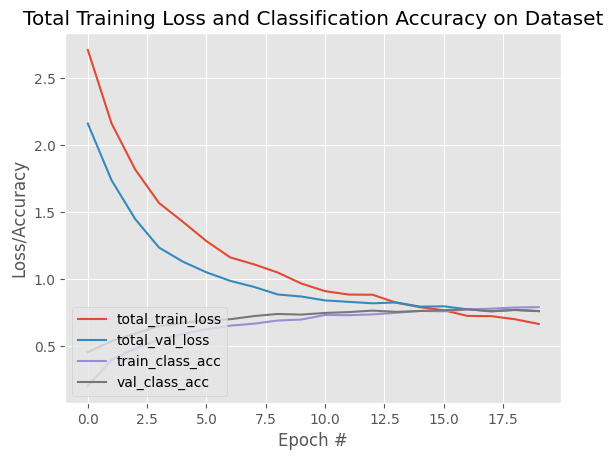

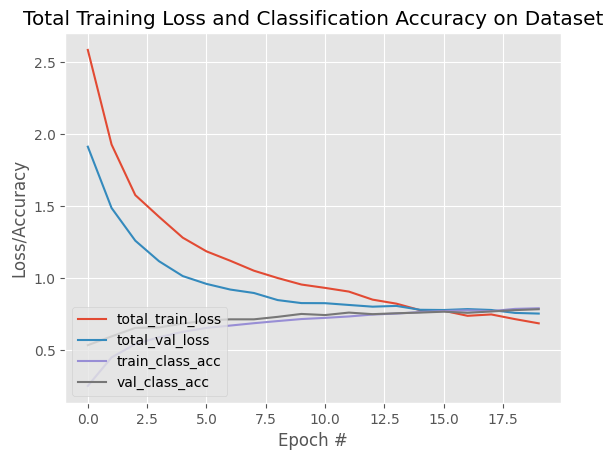

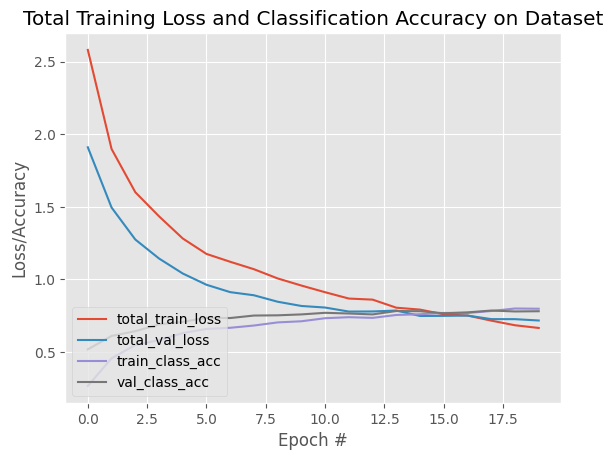

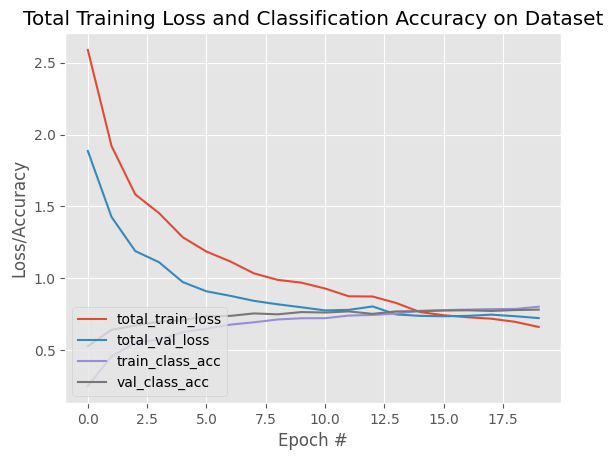

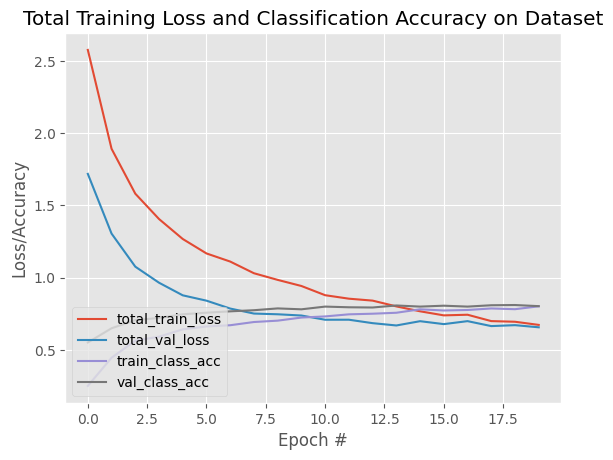

In [21]:
# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(bestmodel, MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()
# plot the training loss and accuracy
for i in range (k):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H[i]["total_train_loss"], label="total_train_loss")
    plt.plot(H[i]["total_val_loss"], label="total_val_loss")
    plt.plot(H[i]["train_class_acc"], label="train_class_acc")
    plt.plot(H[i]["val_class_acc"], label="val_class_acc")
    plt.title("Total Training Loss and Classification Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    # save the training plot
    plotPath = os.path.sep.join([PLOTS_PATH, "training"+"["+str(i)+"]"+".png"])
    plt.savefig(plotPath)

#### Performance metrics calculated on the test Dataset

In order to compare this model created from scratch with the pretrained network, we will now use the remaining 800 samples from the dataset which have not been previously seen by this algorithm's training process and loop those in the network to calculate the average accuracy.

In [22]:
objectDetector = torch.load(MODEL_PATH).to(DEVICE)


#We declare a couple of variables that will store some statistics for metrics calculus later on.
num_classes = len(le.classes_)# Set the number of classes
tp = torch.zeros(num_classes)
fp = torch.zeros(num_classes)
fn = torch.zeros(num_classes)
Test_Correct = 0

with torch.no_grad():
	# set the model in evaluation mode
	objectDetector.eval()
	# loop over the validation set
	for (images, labels, bboxes) in testLoader:
		# send the input to the device
		(images, labels, bboxes) = (images.to(DEVICE),labels.to(DEVICE), bboxes.to(DEVICE))
		# make the predictions and calculate the validation loss
		predictions = objectDetector(images)
		# calculate the number of correct predictions
		Test_Correct += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()

# calculate the test accuracy
Test_Accuracy = Test_Correct / len(TestDS)


print("The accuracy obtained by the trained model in the test Dataset is: {:.4f}".format(Test_Accuracy))

for i in range(num_classes):
	tp[i] += ((predictions[1].argmax(1) == i) & (labels == i)).sum().item()
	fp[i] += ((predictions[1].argmax(1) == i) & (labels != i)).sum().item()
	fn[i] += ((predictions[1].argmax(1) != i) & (labels == i)).sum().item()
	
test_precision = tp / (tp + fp + 1e-8)  # Add a small epsilon to avoid division by zero
test_recall = tp / (tp + fn + 1e-8)
avg_test_precision = np.mean(test_precision.cpu().numpy())
avg_test_recall = np.mean(test_recall.cpu().numpy())

print(f'Average Precision: {avg_test_precision:.4f}')
print(f'Average Recall: {avg_test_recall:.4f}')

The accuracy obtained by the trained model in the test Dataset is: 0.7662
Average Precision: 0.6167
Average Recall: 0.6250


#### Showing the output images 

Now we are going to test the already trained network on another reduced set of images created with the same script that was used to create the reduced training dataset.

[INFO] loading object detector...


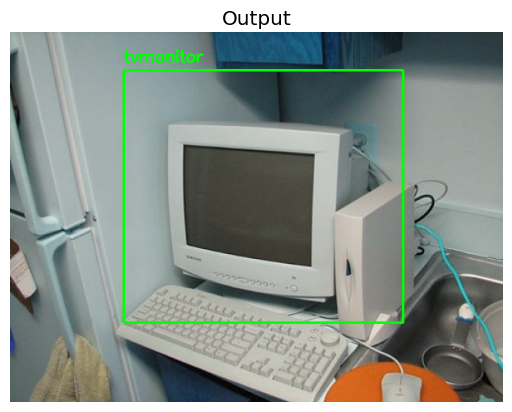

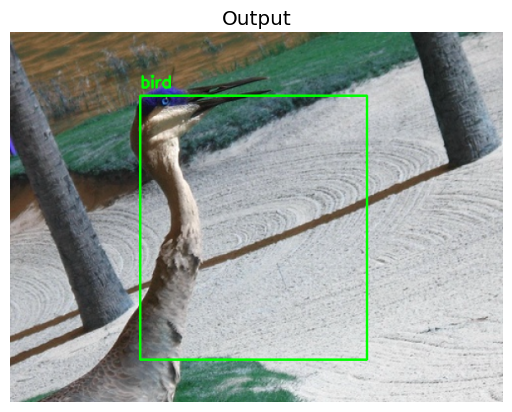

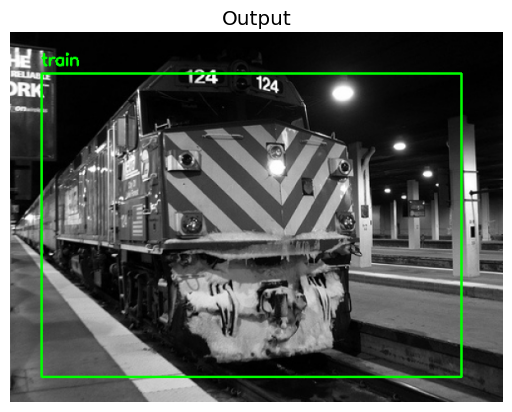

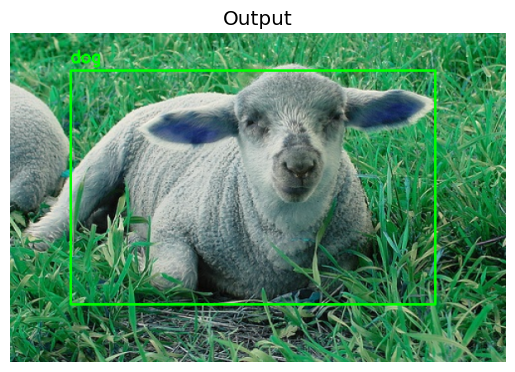

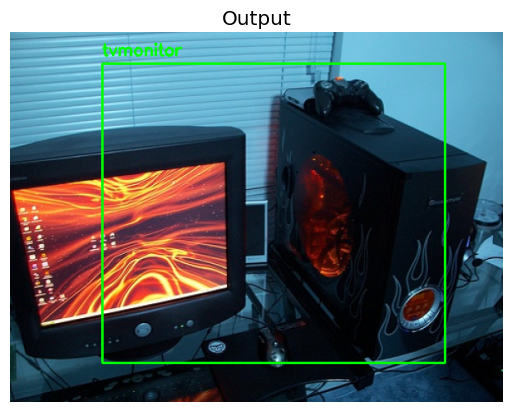

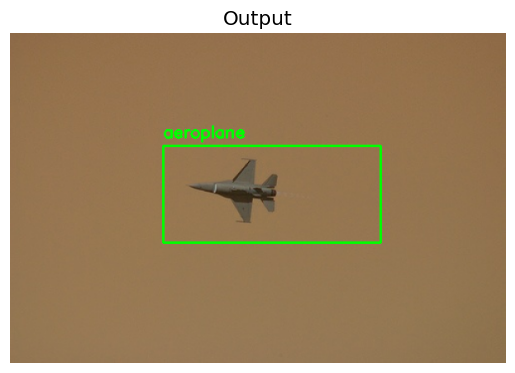

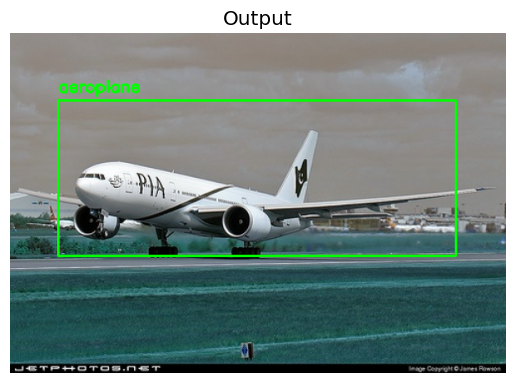

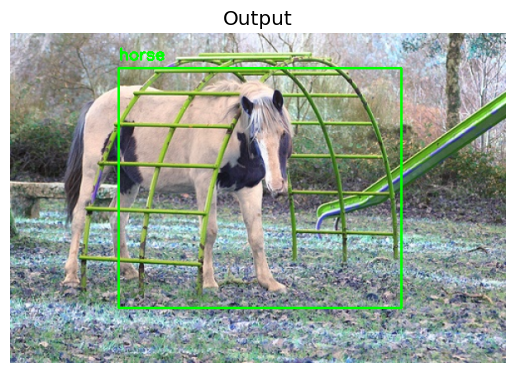

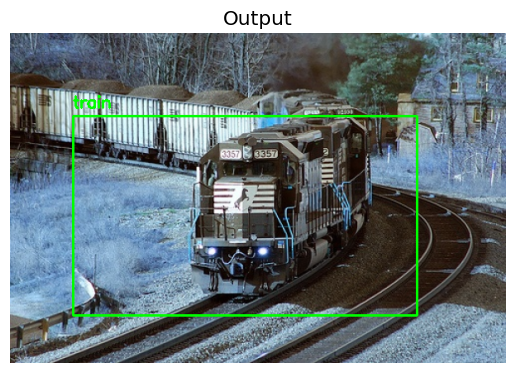

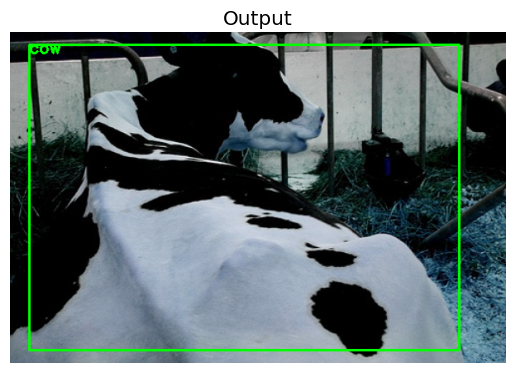

In [23]:
# construct the argument parser and parse the arguments, we override it in the jupyter document like this:
sys.argv = ["object_detection_pytorch.ipynb", "--input", "VOC2012//Images_Reduced_Test"]

ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", required=True, help="path to input image/text file of image paths")
args = vars(ap.parse_args())

imagePaths = args["input"] #we take the path to our image/images

# load our object detector, set it to evaluation mode, and load the label encoder from disk that we have previously created
print("[INFO] loading object detector...")
model = torch.load(MODEL_PATH).to(DEVICE)
model.eval()
le = pickle.loads(open(LE_PATH, "rb").read())
# The transforms are already defined from before

# loop over the images that we'll be testing 
for element in os.listdir(imagePaths):
	#just like we did in training, load the image, copy it, swap its colors channels, resize it, and bring its channel dimension forward
	imagePath = os.path.join(imagePaths, element)
	image = cv2.imread(imagePath)
	orig = image.copy()
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	image = image.transpose((2, 0, 1))
	# convert image to PyTorch tensor, normalize it, flash it to the current device, and add a batch dimension
	image = torch.from_numpy(image)
	image = transforms(image).to(DEVICE)
	image = image.unsqueeze(0)
	
	# predict the bounding box of the object along with the class label
	(boxPreds, labelPreds) = model(image)
	(startX, startY, endX, endY) = boxPreds[0]
	# determine the class label with the largest predicted probability using the inverse transform from the label encoder
	labelPreds = torch.nn.Softmax(dim=-1)(labelPreds)
	i = labelPreds.argmax(dim=-1).cpu()
	label = le.inverse_transform(i)[0]
	
	# resize the original image such that it fits on our screen, and grab its dimensions
	orig = imutils.resize(orig, width=600)
	(h, w) = orig.shape[:2]
	# scale the predicted bounding box coordinates based on the image
	# dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)
	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(orig, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
	cv2.rectangle(orig, (startX, startY), (endX, endY),(0, 255, 0), 2)
	# show the output image 
	# show the output image using matplotlib
	plt.figure()
	plt.imshow(orig)
	plt.title('Output')
	plt.axis('off')
	plt.show()